<a href="https://colab.research.google.com/github/mouliiii21/garbage-classification-project/blob/main/finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_dir= r"C:\Users\User\Downloads\garbage\garbage"
image_size = (124, 124)
batch_size = 32
seed = 42

In [5]:
import zipfile
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
zip_path = r"/content/drive/My Drive/garbage.zip"  # Corrected path to the zip file
extract_path = "/content/extracted_garbage"  # A new directory for extraction

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Update train_data_dir to point to the extracted data
# Assuming the zip file extracts to a structure like 'garbage/TrashType_Image_Dataset'
train_data_dir = os.path.join(extract_path, "garbage", "TrashType_Image_Dataset")

# Now you can create your data generators from the extracted directory
# train_datagen = ImageDataGenerator(rescale=1./255) # Keep this definition
# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(124, 124),
#     batch_size=32,
#     class_mode='binary', # Or 'categorical' depending on your labels
#     subset='training' # If you are using validation_split in ImageDataGenerator
# )

# Note: The lines for creating train_datagen and train_generator are commented out
# because you already have them defined later or might need to adjust parameters
# based on your full dataset splitting strategy.
# You should uncomment and adjust them as needed after executing this cell.

In [7]:
# prompt: code for validation of datset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(124, 124),
    batch_size=32,
    class_mode='categorical', # Or 'binary' depending on your labels
    subset='training',
    seed=seed
)

# Create the validation generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(124, 124),
    batch_size=32,
    class_mode='categorical', # Or 'binary' depending on your labels
    subset='validation',
    seed=seed
)

Found 90 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [8]:
# prompt: get the total number of batches in the validation dataset

total_validation_batches = len(validation_generator)
print(f"Total number of batches in the validation dataset: {total_validation_batches}")

Total number of batches in the validation dataset: 1


In [9]:
# prompt: Split the validation dataset into two equal parts: First half becomes the test dataset and Second half remains as the validation dataset

total_batches_for_test = total_validation_batches // 2
total_batches_for_validation = total_validation_batches - total_batches_for_test

test_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(124, 124),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(124, 124),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Number of batches in the test dataset: {len(test_generator)}")
print(f"Number of batches in the validation dataset: {len(validation_generator)}")

Found 18 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Number of batches in the test dataset: 1
Number of batches in the validation dataset: 1


In [10]:
# prompt: print the class names of the validation dataset and training dataset

# Access class names from the class_indices attribute
print("Training dataset class names:", list(train_generator.class_indices.keys()))
print("Validation dataset class names:", list(validation_generator.class_indices.keys()))

Training dataset class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Validation dataset class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


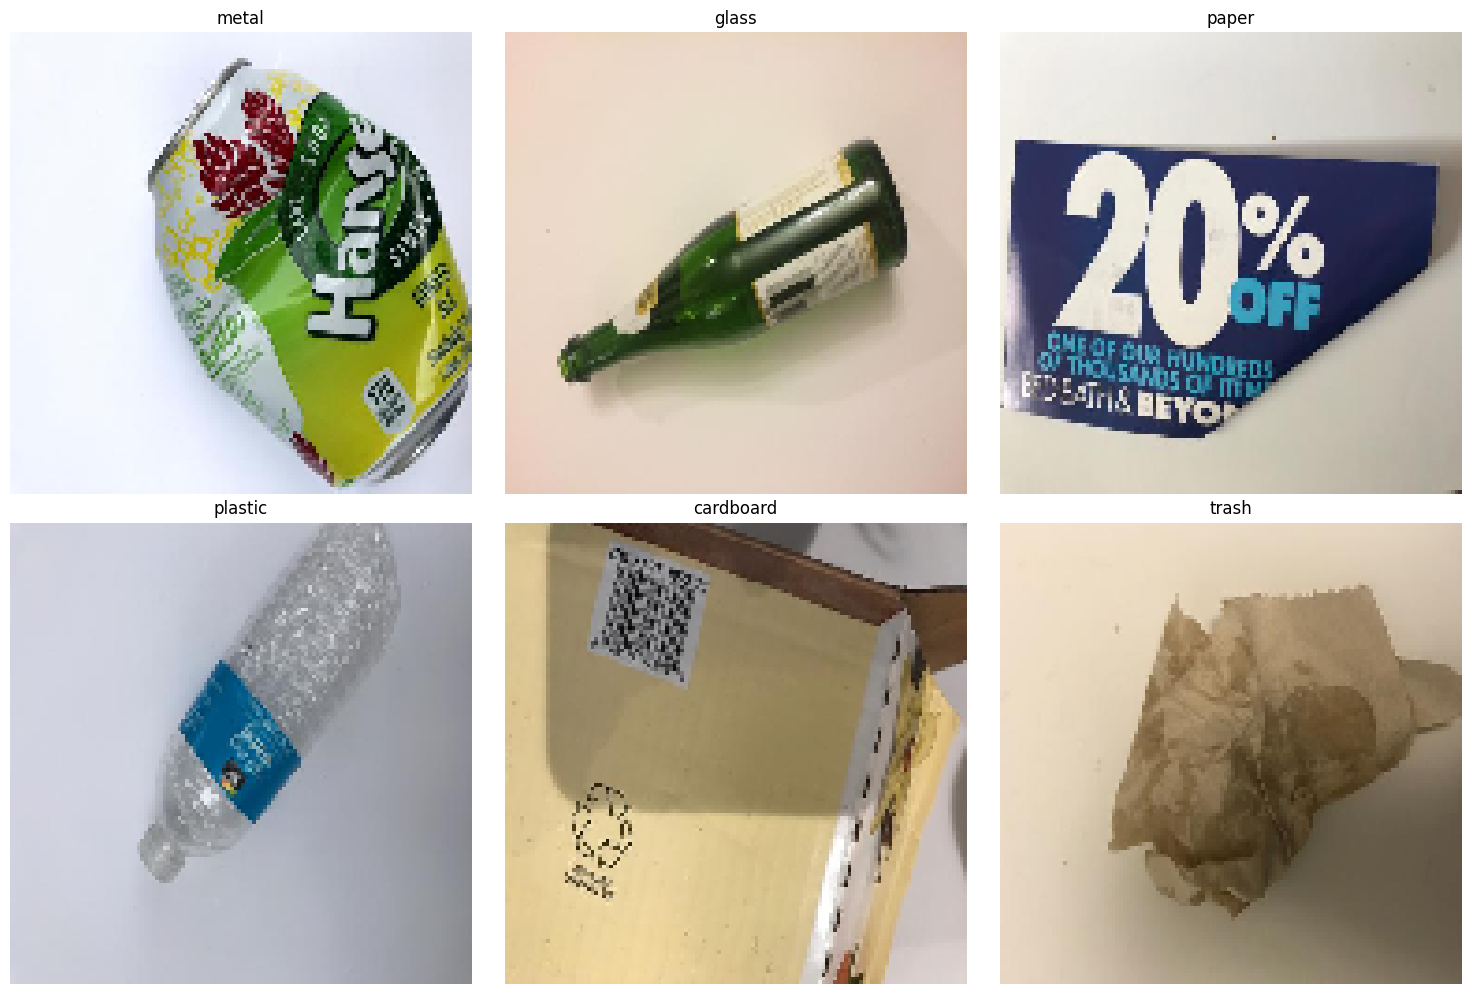

In [11]:
# prompt: Visualize sample images from each class.

# Get class labels and indices
class_labels = list(train_generator.class_indices.keys())

# Get one batch of training data
images, labels = next(train_generator)

# Number of samples to display per class (up to the batch size)
samples_per_class = 1

# Dictionary to store the first image encountered for each class
class_images = {}

# Iterate through the batch to find one image per class
for i in range(images.shape[0]):
    image = images[i]
    label_index = np.argmax(labels[i])
    class_name = class_labels[label_index]

    if class_name not in class_images:
        class_images[class_name] = image
    if len(class_images) == len(class_labels):
        break # Found at least one image for each class

# Plot the sample images
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [13]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

Training distribution: {'cardboard': np.float64(16.67), 'glass': np.float64(16.67), 'metal': np.float64(16.67), 'paper': np.float64(16.67), 'plastic': np.float64(16.67), 'trash': np.float64(16.67)}
Validation distribution: {'cardboard': np.float64(16.67), 'glass': np.float64(16.67), 'metal': np.float64(16.67), 'paper': np.float64(16.67), 'plastic': np.float64(16.67), 'trash': np.float64(16.67)}
Test distribution: {'cardboard': np.float64(16.67), 'glass': np.float64(16.67), 'metal': np.float64(16.67), 'paper': np.float64(16.67), 'plastic': np.float64(16.67), 'trash': np.float64(16.67)}
Overall distribution (approx): {'cardboard': np.float64(16.67), 'glass': np.float64(16.67), 'metal': np.float64(16.67), 'paper': np.float64(16.67), 'plastic': np.float64(16.67), 'trash': np.float64(16.67)}


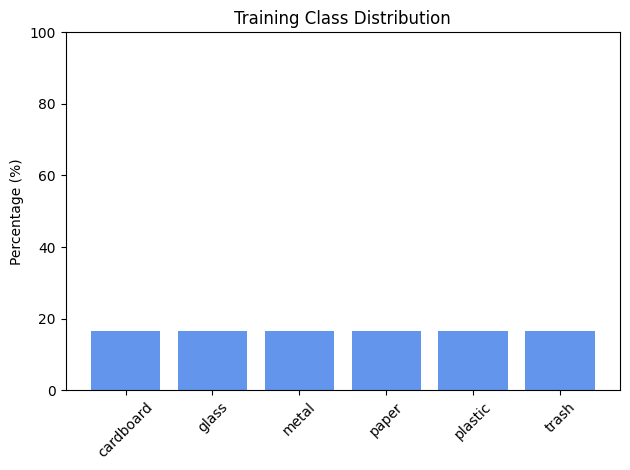

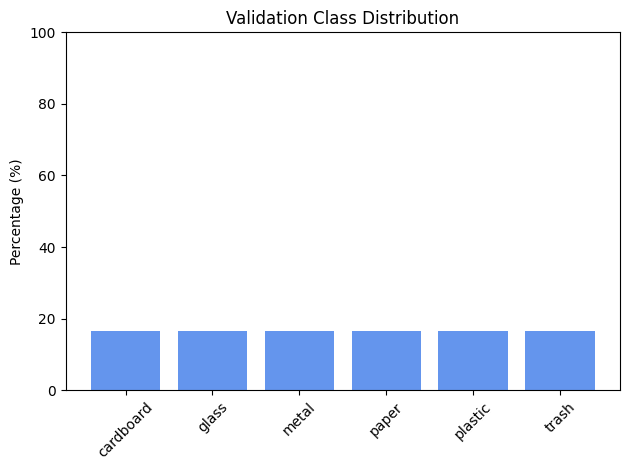

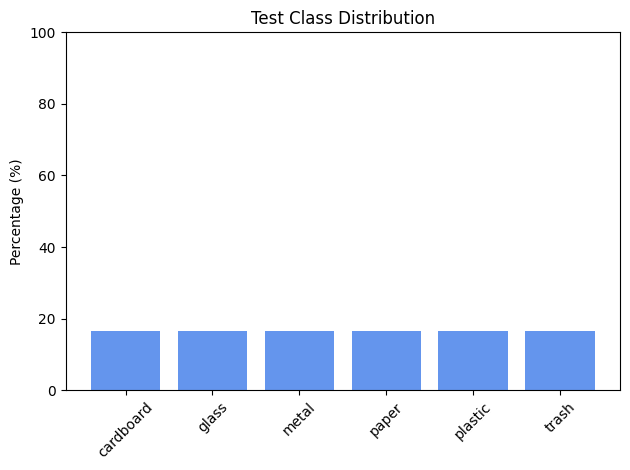

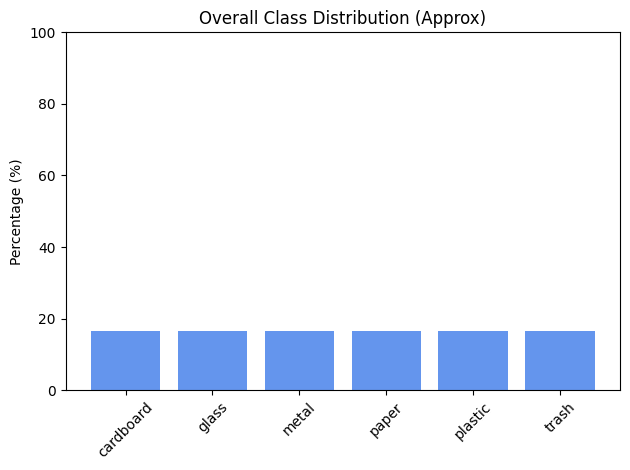

In [14]:
# Get class names from the generator's class_indices
class_names = list(train_generator.class_indices.keys())

# Function to calculate class distribution from a DirectoryIterator
def count_distribution_from_iterator(iterator, class_names):
    """Calculates the class distribution for a DirectoryIterator."""
    if not hasattr(iterator, 'classes'):
        print("Warning: Iterator does not have a 'classes' attribute. Cannot calculate distribution efficiently.")
        return None

    unique_classes, counts = np.unique(iterator.classes, return_counts=True)
    total_samples = iterator.n
    distribution = {}
    for i, class_index in enumerate(unique_classes):
        class_name = class_names[class_index]
        count = counts[i]
        percentage = (count / total_samples) * 100 if total_samples > 0 else 0
        distribution[class_name] = round(percentage, 2)

    return distribution

# Get class distributions using the updated function
train_dist = count_distribution_from_iterator(train_generator, class_names)
val_dist = count_distribution_from_iterator(validation_generator, class_names)
test_dist = count_distribution_from_iterator(test_generator, class_names)

# Calculate overall distribution (assuming train, val, test cover the whole dataset)
# A more accurate overall distribution would be to count from the source directory.
overall_dist = {}
if train_dist and val_dist and test_dist:
    for k in class_names:
        # Simple average of percentages - this is an approximation
        # A more accurate way is to sum the raw counts from each split and then calculate percentages
        overall_dist[k] = round((train_dist[k] + val_dist[k] + test_dist[k]) / 3, 2)
elif train_dist and val_dist:
     for k in class_names:
        overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)
else:
    print("Could not calculate overall distribution from available distributions.")


print("Training distribution:", train_dist)
print("Validation distribution:", val_dist)
print("Test distribution:", test_dist)
print("Overall distribution (approx):", overall_dist)

# You might want to plot these distributions using your simple_bar_plot function
simple_bar_plot(train_dist, "Training Class Distribution")
simple_bar_plot(val_dist, "Validation Class Distribution")
simple_bar_plot(test_dist, "Test Class Distribution")
simple_bar_plot(overall_dist, "Overall Class Distribution (Approx)")

In [33]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.15), # Increased rotation
    layers.RandomZoom(height_factor=0.15, width_factor=0.15), # Increased zoom
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Added translation
    layers.RandomBrightness(factor=0.1), # Added brightness adjustment
    layers.RandomContrast(factor=0.15), # Slightly increased contrast adjustment
])

In [34]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

In [17]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [18]:
# prompt: code to compile the model

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multiple classes
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [19]:
# prompt: Define an EarlyStopping callback to stop training when validation loss stops improving

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [20]:
# prompt: Set the number of epochs to train the model and Train the model using the fit function

#@title Number of Epochs
epochs = 15 #@param {type:"integer"}

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Add the early stopping callback here
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2266 - loss: 1.8197

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.2227 - loss: 1.8183 - val_accuracy: 0.1667 - val_loss: 1.8321
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1803 - loss: 1.8334 - val_accuracy: 0.1667 - val_loss: 1.8374
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2244 - loss: 1.8205 - val_accuracy: 0.1667 - val_loss: 1.8372
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2205 - loss: 1.7679 - val_accuracy: 0.1667 - val_loss: 1.8315
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.2898 - loss: 1.7522 - val_accuracy: 0.1667 - val_loss: 1.8245
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2782 - loss: 1.7023 - val_accuracy: 0.1667 - val_loss: 1.8206
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2355 - loss: 1.7485 - val_accuracy: 0.1667 - val_loss: 1.8206
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2569 - loss: 1.6874 - val_accuracy: 0.1667 - val_loss: 1.8175
Epoch 9/15
3/3 ━━━━━━━━━━

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [23]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

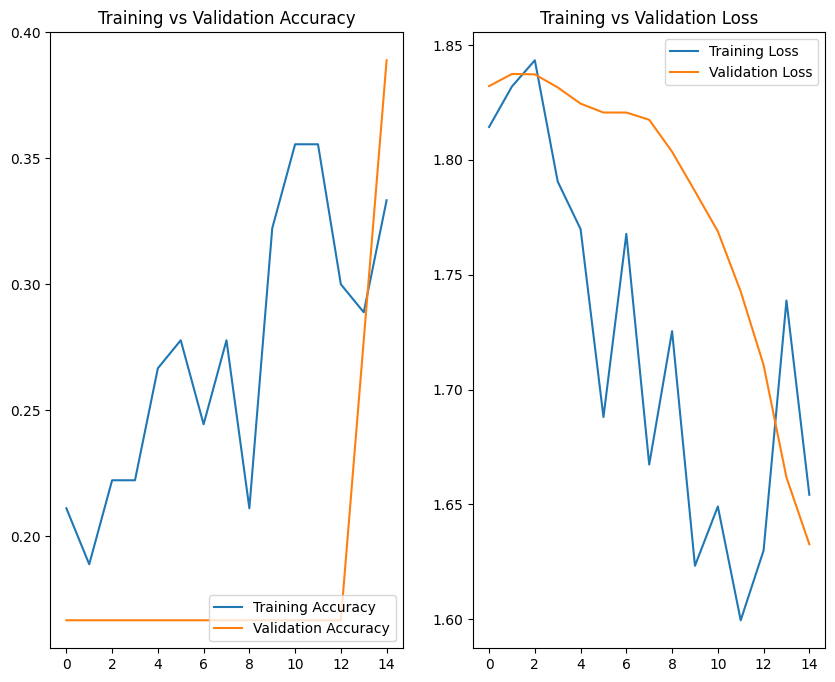

In [35]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()

In [26]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step - accuracy: 0.3889 - loss: 1.6327
Test accuracy is 0.3889, Test loss is 1.6327


In [28]:
# Extract true labels from the test dataset
# For DirectoryIterator, true labels are available in the .classes attribute
y_true = test_generator.classes

# Get predictions as probabilities from the model
# Use predict with the generator
y_pred_probs = model.predict(test_generator)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the class names in the order they appear in the generator
class_names = list(test_generator.class_indices.keys())

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)

# Print metrics to assess model performance
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names)) # Add target_names for better readability

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix:
[[0 3 0 0 0 0]
 [0 2 0 0 1 0]
 [0 2 0 1 0 0]
 [0 1 0 0 2 0]
 [0 2 0 0 1 0]
 [0 1 0 0 1 1]]

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00         3
       glass       0.18      0.67      0.29         3
       metal       0.00      0.00      0.00         3
       paper       0.00      0.00      0.00         3
     plastic       0.20      0.33      0.25         3
       trash       1.00      0.33      0.50         3

    accuracy                           0.22        18
   macro avg       0.23      0.22      0.17        18
weighted avg       0.23      0.22      0.17        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


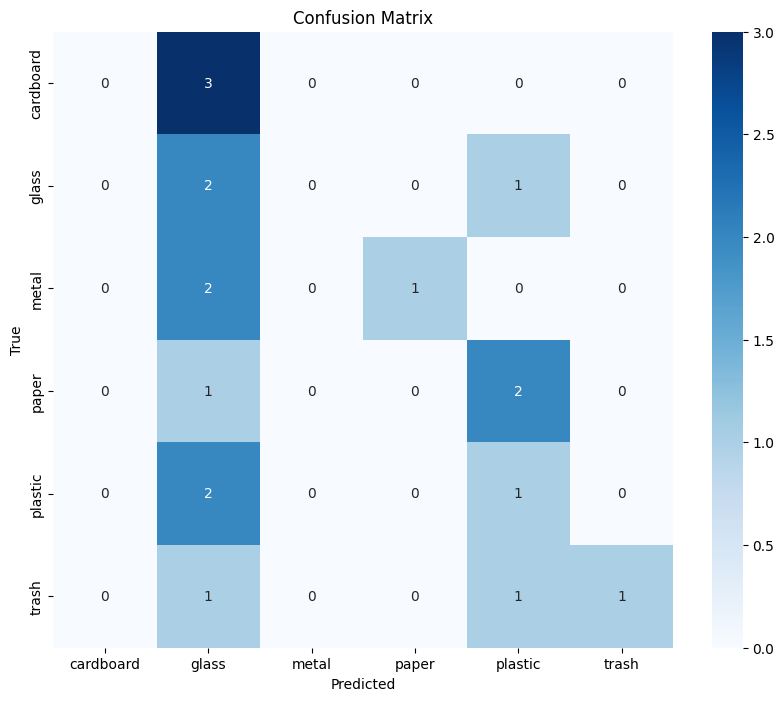

In [36]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

Training dataset class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


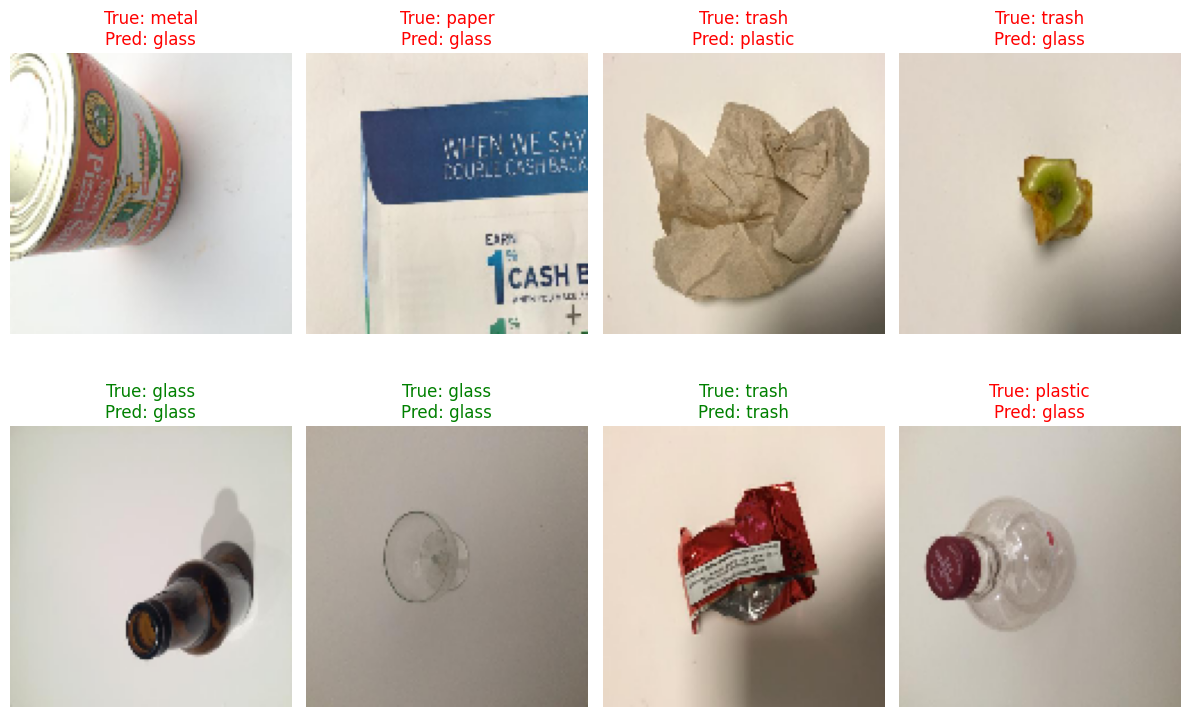

In [37]:
# prompt: Extract class names from the training dataset and Take one batch of images and labels from the test dataset for evaluation then  Generate predictions for the batch of images and then Get the predicted class index for each image. Loop through the first 8 images in the batch

# Access class names from the training generator
class_names = list(train_generator.class_indices.keys())
print("Training dataset class names:", class_names)

# Take one batch of images and labels from the test dataset
test_images, test_labels = next(test_generator)

# Generate predictions for the batch of images
predictions = model.predict(test_images)

# Get the predicted class index for each image
predicted_classes = np.argmax(predictions, axis=1)

# Loop through the first 8 images in the batch
plt.figure(figsize=(12, 8))
for i in range(min(8, len(test_images))):
    plt.subplot(2, 4, i + 1)
    plt.imshow(test_images[i])

    true_label_index = np.argmax(test_labels[i])
    true_label = class_names[true_label_index]
    predicted_label = class_names[predicted_classes[i]]

    color = 'green' if true_label == predicted_label else 'red'

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()